In [ ]:
!pip install japanize-matplotlib
!pip install openai
import openai
import json
openai.api_key = "XXXXXXXXXXXXXXXXXX"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 69.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=7b8619d594d635ceb678ee3d484c227d39fd245774143cc094d0d676596272cf
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
#@title クラス定義
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import time

class TransR(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, projection_dim):
        super(TransR, self).__init__()

        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.projection_dim = projection_dim

        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, projection_dim)
        self.projection_matrices = nn.Embedding(num_relations, embedding_dim * projection_dim)

        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        nn.init.xavier_uniform_(self.relation_embeddings.weight.data)
        nn.init.xavier_uniform_(self.projection_matrices.weight.data)

    def normalize_embeddings(self):
        self.entity_embeddings.weight.data = F.normalize(self.entity_embeddings.weight.data, p=2, dim=1)
        self.relation_embeddings.weight.data = F.normalize(self.relation_embeddings.weight.data, p=2, dim=1)

    def forward(self, heads, relations, tails):
        #self.entity_embeddings(heads)
        #self.entity_embeddings(tails)
        head_embeddings = self.entity_embeddings(heads)
        tail_embeddings = self.entity_embeddings(tails)
        relation_embeddings = self.relation_embeddings(relations)
        projection_matrices = self.projection_matrices(relations).view(-1, self.embedding_dim, self.projection_dim)

        projected_heads = torch.bmm(head_embeddings.unsqueeze(1), projection_matrices).squeeze(1)
        projected_tails = torch.bmm(tail_embeddings.unsqueeze(1), projection_matrices).squeeze(1)

        scores = torch.norm(projected_heads + relation_embeddings - projected_tails, p=2, dim=1)

        #print(scores)
        return scores.clone()


    def get_regularization_term(self, relations, coef):
        l2_reg = torch.norm(self.projection_matrices(relations).view(-1, self.embedding_dim, self.projection_dim), p=2, dim=(1, 2)).clone()
        return coef * l2_reg

    def load_custom_embeddings(self, dataset):
        #self.entity_embeddings.weight.requires_grad = True
        custom_entities = list(dataset.frozen_entities)

        for id in custom_entities:
            entity = list(dataset.entity2id.keys())[id]
            print(id, entity)
            embedding = openai.Embedding.create(input = entity, model="text-embedding-ada-002")['data'][0]['embedding']

            x = torch.tensor(embedding)
            x = x.view(1,-1).to(device)
            output = encoder(x)
            embedding = output.view(-1).tolist()

            self.entity_embeddings.weight.data[id] = torch.tensor(embedding)
            time.sleep(0.5)
            #self.entity_embeddings.weight[id].detach()


    def predict_missing_entity(self, h, t, r, k):
        """
        h: head entity or None
        t: tail entity or None
        r: relation
        """

        self.eval()
        # Check that only one of {h, t} is missing
        assert (h is None) != (t is None)

        # Get the known entity and its role (head or tail)
        known_entity = h if h is not None else t
        role = 'head' if h is not None else 'tail'

        # Fetch embeddings
        known_emb = self.entity_embeddings(known_entity)
        r_emb = self.relation_embeddings(r).expand(self.num_entities, -1)
        M_r = self.projection_matrices(r).view(-1, self.embedding_dim, self.projection_dim)
        #print(M_r.size().squeeze())
        #print(r_emb.size())
        # Transfer the known entity embedding
        #known_emb_transferred = torch.mm(known_emb, M_r)
        known_emb_transferred = torch.bmm(known_emb.unsqueeze(1), M_r).squeeze(1).expand(self.num_entities, -1)
        #print(known_emb_transferred.size())
        # Fetch all entity embeddings
        all_entity_embeddings = self.entity_embeddings.weight.detach()
        #print(all_entity_embeddings.size())
        all_entity_embeddings_transferred = torch.mm(all_entity_embeddings, M_r.squeeze())

        with torch.no_grad():
            if role == 'head':
                scores = torch.norm(known_emb_transferred + r_emb - all_entity_embeddings_transferred, p=2, dim=1).clone()
            else:
                scores = torch.norm(all_entity_embeddings_transferred + r_emb - known_emb_transferred, p=2, dim=1).clone()

        # Move scores back to CPU for further processing
        #scores = scores.cpu()
        #print(scores.size())
        #print(scores)

        # Find the entity with the lowest score
        lowest_scores, predicted_entities = scores.topk(k, largest=False)

        return predicted_entities, lowest_scores

    def predict_extend_tail(self, t_emb, r, frozen_entities):
      self.eval()

      known_emb = t_emb
      r_emb = self.relation_embeddings(r).expand(self.num_entities, -1)
      M_r = self.projection_matrices(r).view(-1, self.embedding_dim, self.projection_dim)

      # Transfer the known entity embedding
      known_emb_transferred = torch.bmm(known_emb.unsqueeze(1), M_r).squeeze(1).expand(self.num_entities, -1)

      # Fetch all entity embeddings
      all_entity_embeddings = self.entity_embeddings.weight.detach()
      all_entity_embeddings_transferred = torch.mm(all_entity_embeddings, M_r.squeeze())

      with torch.no_grad():
          scores = torch.norm(all_entity_embeddings_transferred + r_emb - known_emb_transferred, p=2, dim=1).clone()

      # Set scores of frozen entities to a very large value so they do not appear in the topk
      scores[frozen_entities] = float('inf')

      # Find the entity with the lowest score
      lowest_scores, predicted_entities = scores.topk(10, largest=False)

      return predicted_entities, lowest_scores





class TripleDataset(Dataset):
    def __init__(self, file_path):
        self.entity2id = {}
        self.relation2id = {}
        self.entity_num = 0
        self.data = []
        self.frozen_entities = set()

        with open(file_path, 'r') as file:
            for line in file:
                head, relation, tail, freeze = line.strip().split()
                #head, relation, tail = line.strip().split("\t")
                freeze = "1"

                if head not in self.entity2id:
                    self.entity2id[head] = len(self.entity2id)
                if tail not in self.entity2id:
                    self.entity2id[tail] = len(self.entity2id)
                if relation not in self.relation2id:
                    self.relation2id[relation] = len(self.relation2id)

                if freeze == '1':
                    self.frozen_entities.add(self.entity2id[tail])

                self.data.append((self.entity2id[head], self.relation2id[relation], self.entity2id[tail]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
lines_list = []
with open('/content/knowledge_graph_data.txt', 'r') as file:
    for line in file:
        lines_list.append(line.strip())

#print(lines_list)
cnt = 0
obj_list = []

for t in lines_list:
  if t == "":
    if cnt == 0:
      cnt = 1
    else:
      obj["list"] = c_list
      obj_list.append(obj)
      cnt = 0
  else:
    if cnt == 0:
      obj = {"name": t}
      c_list = []
    else:
      c_list.append(t.replace("・", ''))

text = ""
for obj in obj_list:
  for t in obj["list"]:
    text = f"{text}{obj['name']} 性格 {t} 1\n"

print(text)

In [ ]:
dataset = TripleDataset('/content/dataset.txt')

In [ ]:
list(dataset.frozen_entities)

In [ ]:
#@title エンコーダーモデル定義
import torch
import torch.nn as nn
from torch.nn import CosineSimilarity
import torch.nn.functional as F
from torch.utils.data import Dataset

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        output = self.fc3(h)
        output_norm = output / output.norm(p=2, dim=1, keepdim=True)  # Normalize the output vector
        return output_norm


class WordPairDataset(Dataset):
    def __init__(self, filepath, word_vectors):
        self.filepath = filepath
        self.word_vectors = word_vectors
        self.samples = self.load_samples()

    def load_samples(self):
        samples = []
        with open(self.filepath, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue  # Ignore lines that do not have exactly three parts
                word1, word2, score_str = parts
                if word1 not in self.word_vectors or word2 not in self.word_vectors:
                    continue  # Ignore words that are not in the word vectors
                try:
                    score = float(score_str)
                except ValueError:
                    continue  # Ignore scores that cannot be converted to a float
                samples.append((self.word_vectors[word1], self.word_vectors[word2], score))
        return samples

    def __getitem__(self, index):
        word_vector1, word_vector2, score = self.samples[index]

        # Convert word vectors from list to tensor
        word_tensor1 = torch.tensor(word_vector1, dtype=torch.float32)
        word_tensor2 = torch.tensor(word_vector2, dtype=torch.float32)

        # Convert score to float tensor
        score = torch.tensor(score, dtype=torch.float32)

        return word_tensor1, word_tensor2, score

    def __len__(self):
        return len(self.samples)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder_path = "/content/drive/MyDrive/scraping/character_encoder/model1000.json"#@param {type:"string"}
with open(encoder_path, 'r') as f:
    e_config = json.load(f)
# Initialization
encoder = Encoder(1536, e_config["emb_size"]).to(device)

encoder.load_state_dict(torch.load(e_config["model_path"]))
encoder.eval()

Encoder(
  (fc1): Linear(in_features=1536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=300, bias=True)
)

In [ ]:
#@title 学習ステップ
from torch.optim import Adam
import random
loss_list = []

# Hyperparameters
learning_rate = 0.01
num_epochs = 500
batch_size = 16
weight_decay = 0.01  # 正規化項


# データセットを作成
dataset = TripleDataset('/content/dataset.txt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DataLoaderを作成
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# モデルを作成
model = TransR(len(dataset.entity2id), len(dataset.relation2id), embedding_dim=300, projection_dim=300)

model.to(device)

model.load_custom_embeddings(dataset)

num_entities = model.num_entities
"""
with torch.no_grad():
    model.entity_embeddings.weight[list(dataset.frozen_entities)].requires_grad = False"""

optimizer = Adam(model.parameters(), lr=learning_rate)  # オプティマイザーの定義
criterion = nn.MarginRankingLoss(margin=5.0)# 損失関数の定義

#model.load_custom_embeddings(custom_entities, custom_embeddings)

for epoch in range(num_epochs):  # 10エポック学習
    for heads, relations, tails in loader:
        heads = heads.to(device)
        relations = relations.to(device)
        tails = tails.to(device)

        optimizer.zero_grad()

        positive_scores = model(heads, relations, tails)  # 正例のスコア

        if random.random() > 0.5:  # With 50% probability
            negative_tails = torch.randint(0, num_entities, tails.shape, device=tails.device) # 負例を生成
            negative_scores = model(heads, relations, negative_tails)  # 負例のスコア
        else:
            """entities_list = [0,19,28,48,57,63,71,82,92,96,105]
            len_entities = len(entities_list)
            # ランダムにインデックスを選択
            random_indices_list = [random.choice(range(len_entities)) for _ in range(heads.shape[0])]
            random_indices = torch.tensor(random_indices_list)

            # ランダムに選択したインデックスを使用してリストから値を取得
            selected_values = [entities_list[index] for index in random_indices.tolist()]
            negative_heads = torch.tensor(selected_values).to(device)"""
            negative_heads = torch.randint(0, num_entities, heads.shape, device=heads.device) # 負例を生成
            negative_scores = model(negative_heads, relations, tails)  # 負例のスコア

        reg_term = model.get_regularization_term(relations, weight_decay)
        y = -1 * torch.ones_like(positive_scores)  # ラベルテンソル
        loss = criterion(positive_scores, negative_scores, y) + reg_term
        loss = loss.mean()
        # バックプロパゲーションと重みの更新
        loss.backward()

        for index in list(dataset.frozen_entities):
            model.entity_embeddings.weight.grad[index].zero_()

        optimizer.step()
        model.normalize_embeddings()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        loss_list.append(loss.item())

1 感情的
2 自己卑下的
3 厳格
4 強靭
5 激昂しやすい
6 用心深い
7 愛情深い
8 忠実
10 冷静沈着
11 自己犠牲的
12 高慢
13 洞察力が高い
14 面倒見が良い
15 独立心が強い
16 忠義深い
17 辛辣
19 自己中心的
20 怒りっぽい
21 プライドが高い
22 空気が読めない
23 無謀
24 口が軽い
25 非調和的
26 情が深い
27 頑固
28 忍耐強い
30 勇猛果敢
31 思いやりがある
32 正義感が強い
33 柔軟性がある
34 共感力が欠ける
35 自立心が強い
36 友好的
38 エキセントリック
39 無慈悲
40 不可解
41 冷酷
42 狡猾
43 執念深い
44 長期的な視点
45 偏執的
47 直情径行
48 強気
49 思慮深い
50 仁義に厚い
51 読書家
52 内省的
53 恋愛感情に不器用
54 自尊心が強い
55 自信家
57 リアリスト
58 計算高い
59 情に流されやすい
60 うっかり者
61 オーバーリアクション
62 策略的
63 運が悪い
64 冷静
65 交渉上手
66 努力家
67 友情に厚い
68 平和主義者
70 愛妻家
71 利他的
72 献身的
73 無私
74 情熱的
75 無口
76 復讐心が強い
77 感謝深い
78 穏やか
80 礼儀正しい
81 理性的
82 理想主義的
83 性善説主義者
84 誠実
86 勤勉
87 情緒不安定
88 自己矛盾的
89 狂信的
90 執拗
91 非情
92 自傷的
93 無価値観
94 無責任
96 他人思い
97 理知的
98 子供っぽい
99 恋愛に対して無知
100 古風
101 無邪気
102 共感性が高い
103 謙虚
104 内向的
106 無愛想
107 ツンデレ
108 孤独好き
109 自暴自棄
110 家族思い
111 意地っ張り
112 寂しがりや
114 妖艶
115 狂気的
116 好戦的
117 異常な興奮を覚える
118 戦略的
119 身体能力が高い
120 欲深い
122 責任感が強い
123 お茶目
124 繊細
126 好奇心旺盛
127 自立的
128 親切
129 調和的
130 ロマンチック
132 度胸がある
133 実利主義者
134 義理人情に厚い
135 反骨精神

In [ ]:
#@title テールエンティティ予測
h = 28
r = 0
k = 30
predicted_entities, lowest_scores = model.predict_missing_entity(torch.LongTensor([h]).to(device),None,torch.LongTensor([r]).to(device),k)

predicted_entities = predicted_entities.tolist()
lowest_scores = lowest_scores.tolist()
#print(predicted_entities)
#print(lowest_scores)
for i in range(len(predicted_entities)):
  print(f"{lowest_scores[i]} : {list(dataset.entity2id.keys())[h]} - {list(dataset.relation2id.keys())[r]} - {list(dataset.entity2id.keys())[predicted_entities[i]]}")

0.8689265251159668 : 忍耐強い - 性格 - 欲深い
0.8976855278015137 : 忍耐強い - 性格 - 無私
0.9529158473014832 : 忍耐強い - 性格 - 度胸がある
0.9622617959976196 : 忍耐強い - 性格 - リーダーシップがある
0.9627982378005981 : 忍耐強い - 性格 - 冷静沈着
0.9684318900108337 : 忍耐強い - 性格 - 不屈
0.9707819819450378 : 忍耐強い - 性格 - 愛情深い
0.9856194853782654 : 忍耐強い - 性格 - 非情
1.0 : 忍耐強い - 性格 - 忍耐強い
1.015705943107605 : 忍耐強い - 性格 - 寂しがりや
1.0158742666244507 : 忍耐強い - 性格 - 傲慢
1.0195354223251343 : 忍耐強い - 性格 - 実直
1.022612452507019 : 忍耐強い - 性格 - 単純
1.0263309478759766 : 忍耐強い - 性格 - 恋愛に対して無知
1.0264095067977905 : 忍耐強い - 性格 - 忠義深い
1.0298792123794556 : 忍耐強い - 性格 - 長期的な視点
1.0312888622283936 : 忍耐強い - 性格 - 才気溢れる
1.0459109544754028 : 忍耐強い - 性格 - 軽々しい
1.0466396808624268 : 忍耐強い - 性格 - 孤独好き
1.0527957677841187 : 忍耐強い - 性格 - 気まぐれ
1.0578691959381104 : 忍耐強い - 性格 - 不可解
1.0698174238204956 : 忍耐強い - 性格 - 情が深い
1.0800116062164307 : 忍耐強い - 性格 - お茶目
1.08356511592865 : 忍耐強い - 性格 - 公正
1.0875567197799683 : 忍耐強い - 性格 - 内省的
1.0974916219711304 : 忍耐強い - 性格 - 高慢
1.1067233085632324 : 忍耐強い - 性格 - 恋愛感

In [ ]:
#@title ヘッドエンティティ予測
t = 33
r = 0
k = 20
predicted_entities, lowest_scores = model.predict_missing_entity(None,torch.LongTensor([t]).to(device),torch.LongTensor([r]).to(device), k)

predicted_entities = predicted_entities.tolist()
lowest_scores = lowest_scores.tolist()
#print(predicted_entities)
#print(lowest_scores)
for i in range(len(predicted_entities)):
  print(f"{lowest_scores[i]} : {list(dataset.entity2id.keys())[predicted_entities[i]]} - {list(dataset.relation2id.keys())[r]} - {list(dataset.entity2id.keys())[t]}")

0.9999999403953552 : 柔軟性がある - 性格 - 柔軟性がある
2.5613906383514404 : 忠義深い - 性格 - 柔軟性がある
3.0229434967041016 : 自暴自棄 - 性格 - 柔軟性がある
3.1554012298583984 : 忠実 - 性格 - 柔軟性がある
3.442068576812744 : オーバーリアクション - 性格 - 柔軟性がある
3.7494843006134033 : ロズワール - 性格 - 柔軟性がある
3.8280797004699707 : 無私 - 性格 - 柔軟性がある
3.853355646133423 : ペテルギウス - 性格 - 柔軟性がある
3.9133481979370117 : 不可解 - 性格 - 柔軟性がある
3.9731950759887695 : 冷酷 - 性格 - 柔軟性がある
4.003846168518066 : 無慈悲 - 性格 - 柔軟性がある
4.0417304039001465 : 自己中心的 - 性格 - 柔軟性がある
4.057796001434326 : 誠実 - 性格 - 柔軟性がある
4.06507682800293 : 無責任 - 性格 - 柔軟性がある
4.19766902923584 : エキセントリック - 性格 - 柔軟性がある
4.260405540466309 : 自己犠牲的 - 性格 - 柔軟性がある
4.407962799072266 : フェリックス - 性格 - 柔軟性がある
4.490193843841553 : 空気が読めない - 性格 - 柔軟性がある
4.531030178070068 : 欲深い - 性格 - 柔軟性がある
4.638991832733154 : 身体能力が高い - 性格 - 柔軟性がある


In [ ]:
#@title hit@k予測
data_num = 0
head_num = 0
tail_num = 0
k = 10

test_loader = DataLoader(dataset, batch_size=1, shuffle=True)
for heads, relations, tails in test_loader:
  heads = heads.to(device)
  relations = relations.to(device)
  tails = tails.to(device)
  predicted_heads, _ = model.predict_missing_entity(None,tails,relations,k)
  predicted_tails, _ = model.predict_missing_entity(heads,None,relations,k)

  is_in_head = (predicted_heads == heads).any()
  is_in_tail = (predicted_tails == tails).any()
  if is_in_head:
    head_num = head_num + 1

  if is_in_tail:
    tail_num = tail_num + 1
  data_num = data_num + 1

print(f"hit@{k}(head) : {head_num / data_num}")
print(f"hit@{k}(tail) : {tail_num / data_num}")

hit@10(head) : 0.215
hit@10(tail) : 0.19


In [ ]:
#@title セマンティック予測
input_text = "冷静"
emb = openai.Embedding.create(input = input_text, model="text-embedding-ada-002")['data'][0]['embedding']
x = torch.tensor(emb).to(device)
x = x.view(1,-1)
output = encoder(x)
emb = output.view(-1).tolist()
r = 0

predicted_entities, lowest_scores = model.predict_extend_tail(torch.Tensor([emb]).to(device), torch.LongTensor([r]).to(device),list(dataset.frozen_entities))

predicted_entities = predicted_entities.tolist()
lowest_scores = lowest_scores.tolist()
#print(predicted_entities)
#print(lowest_scores)
for i in range(len(predicted_entities)):
  print(f"{lowest_scores[i]} : {list(dataset.entity2id.keys())[predicted_entities[i]]} - {list(dataset.relation2id.keys())[r]} - {input_text}")

0.5802240967750549 : ペテルギウス - 性格 - 冷静
0.6040791273117065 : フェルト - 性格 - 冷静
0.7672988176345825 : ベアトリス - 性格 - 冷静
0.781851589679718 : ミネルヴァ - 性格 - 冷静
1.0125880241394043 : ユリウス - 性格 - 冷静
1.0179277658462524 : エキドナ - 性格 - 冷静
1.025010347366333 : プリシラ - 性格 - 冷静
1.0379358530044556 : エルザ - 性格 - 冷静
1.0608241558074951 : ロズワール - 性格 - 冷静
1.135909914970398 : クルシュ - 性格 - 冷静


In [ ]:
#@title 学習モデルを保存
import torch
import json

model_path = "/content/drive/MyDrive/pretrained/transr_model10000.pth"
config_path = "/content/drive/MyDrive/pretrained/transr_model10000.json"


# PyTorchのモデル保存関数を使用してモデルを保存します。
torch.save(model.state_dict(), model_path)

e_config = {"num_epochs":num_epochs,"embedding_dim":1536,"projection_dim":100,"entity_size":len(dataset.entity2id),"relation_size":len(dataset.relation2id),"batch_size":batch_size,"learning_rate":learning_rate,"weight_decay":weight_decay,"model_path":model_path}

#torch.save(model.state_dict(), model_path)

# JSON形式でファイルに書き出す
with open(config_path, 'w') as f:
    json.dump(e_config, f)

In [ ]:
#@title 学習モデルを再ロード
import torch

# ここで、TransRModelは保存したモデルと同じ構造を持つ新たなモデルを作成するクラスを表します。
# これはあなたが定義したモデルクラスや使用したライブラリによります。

transr_model = TransR(len(dataset.entity2id), len(dataset.relation2id), embedding_dim=1536, projection_dim=100)

# 保存先のファイルパスを指定します。
model_path = "/content/drive/MyDrive/pretrained/transr_model.pth"

# PyTorchのパラメータロード関数を使用してモデルのパラメータをロードします。
transr_model.load_state_dict(torch.load(model_path))



<All keys matched successfully>

In [ ]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


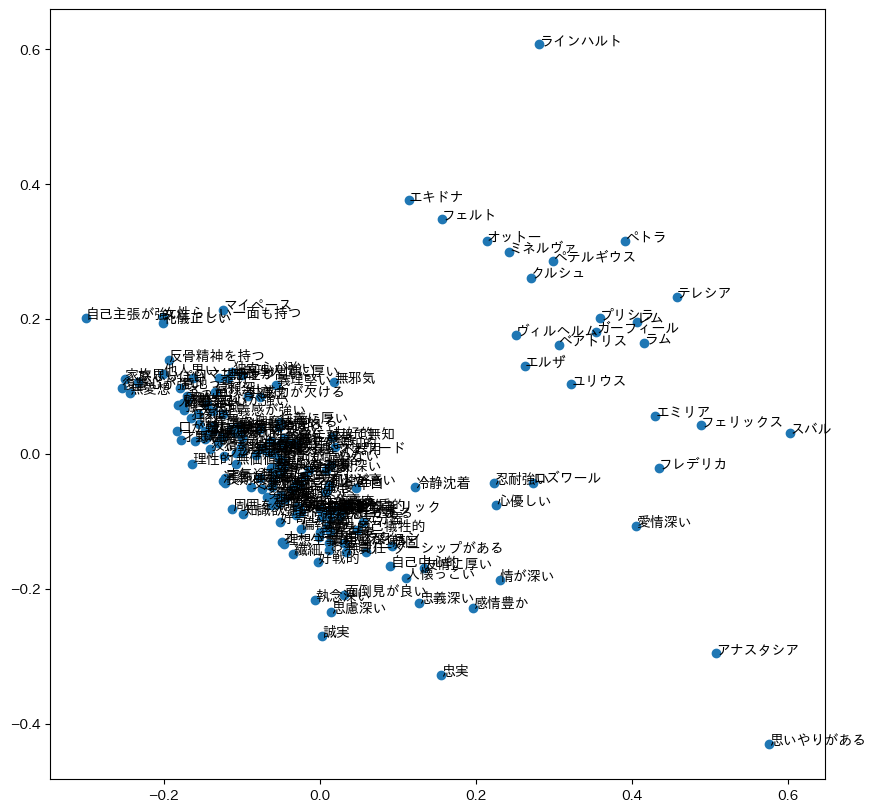

In [ ]:
#@title 埋め込みマッピング
import torch
from sklearn.decomposition import PCA
import japanize_matplotlib
import matplotlib.pyplot as plt

# 前提：self.entity_embeddingsはあなたのEmbedding層で、num_entitiesがエンティティの数です
# また、エンティティの名前を表すentity_namesのようなリストがあるとします。

entity_names = list(dataset.entity2id.keys())  # エンティティの名前を含むリスト

# 埋め込みを取得します。detach()を使用して、計算から埋め込みを切り離します。
# そして、numpyに変換します。
embeddings = model.entity_embeddings.weight.detach().cpu().numpy()

# PCAインスタンスを作成し、2次元に圧縮します
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 2Dエンベッディングをプロットします
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# エンティティの名前を点に追加します
for i, name in enumerate(entity_names):
    plt.annotate(name, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()

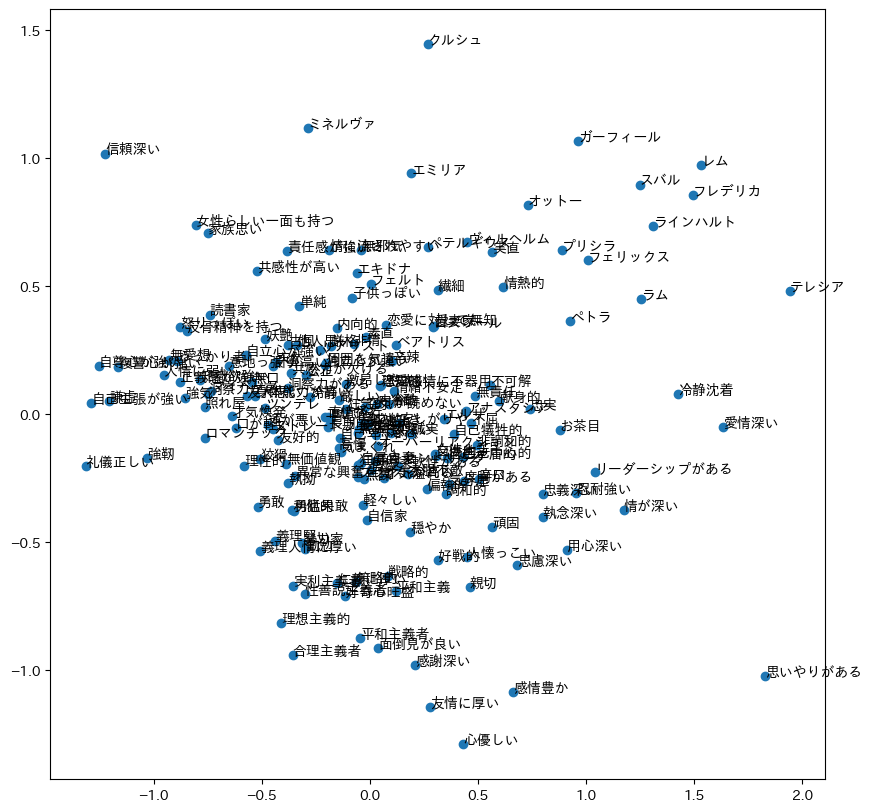

In [ ]:
#@title 転写埋め込みマッピング
import torch
from sklearn.decomposition import PCA
import japanize_matplotlib
import matplotlib.pyplot as plt

# 前提：self.entity_embeddingsはあなたのEmbedding層で、num_entitiesがエンティティの数です
# また、エンティティの名前を表すentity_namesのようなリストがあるとします。

entity_names = list(dataset.entity2id.keys())  # エンティティの名前を含むリスト

# 埋め込みを取得します。detach()を使用して、計算から埋め込みを切り離します。
# そして、numpyに変換します。
#embeddings = model.entity_embeddings.weight.detach().cpu().numpy()
all_entity_embeddings = model.entity_embeddings.weight.detach()
M_r = model.projection_matrices(torch.LongTensor([0]).to(device)).view(-1, model.embedding_dim, model.projection_dim)
all_entity_embeddings_transferred = torch.mm(all_entity_embeddings, M_r.squeeze())
embeddings = all_entity_embeddings_transferred.detach().cpu().numpy()
# PCAインスタンスを作成し、2次元に圧縮します
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 2Dエンベッディングをプロットします
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# エンティティの名前を点に追加します
for i, name in enumerate(entity_names):
    plt.annotate(name, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()


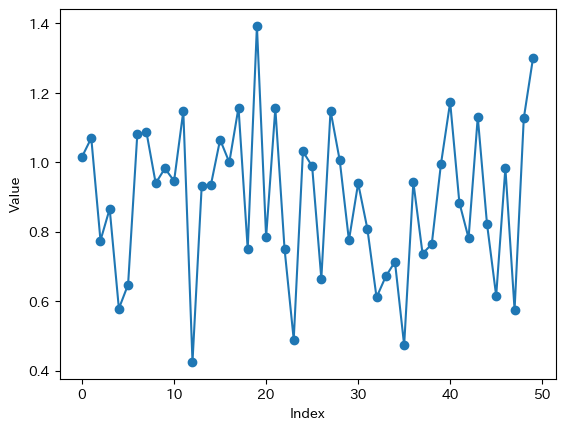

In [ ]:
#@title 損失追跡
import matplotlib.pyplot as plt


# インデックスリストを作成します (0からリストの長さ-1まで)
indices = list(range(len(loss_list)))

# プロットを作成します
plt.plot(indices, loss_list, marker='o')

# 軸のラベルを設定します
plt.xlabel('Index')
plt.ylabel('Value')

# グラフを表示します
plt.show()

In [ ]:
triple_list = []
with open("/content/00_chara_all07-2.txt", 'r') as file:
  for line in file:
    #head, relation, tail, freeze = line.strip().split()
    head, relation, tail = line.strip().split("\t")
    if relation == "Personality":
      triple_list.append(line.strip())

In [ ]:
# テキストファイルを書き込みモードで開く
with open('output.txt', 'w') as f:
    # リストの各要素を行として書き込む
    for text in triple_list:
        f.write(text + '\n')  # '\n'は改行文字

In [ ]:
from sqlalchemy.pool.impl import exc
import ast
triple_list = []
with open("output.txt", 'r') as file:
  for line in file:
    try:
      head, relation, tail = line.strip().split("\t")
      triple_list.append(f"{head}\t{relation}\t{tail}")
      response = openai.ChatCompletion.create(
              model="gpt-3.5-turbo",
              messages=[{"role": "user", "content": """以下のワードと同じ性格を表す英語のワードを3つ、例のような形式で出力してください。
              例：['','','']
              出力："""},
                        {"role": "system", "content": f"{tail}"},],
              temperature=0,
      )
      real_list = ast.literal_eval(response["choices"][0]["message"]["content"].strip())
      for w in real_list:
        triple_list.append(f"{head}\t{relation}\t{w}")
    except:
      print(f"error : {line.strip()}")

error : ロズワール・L・メイザース	Personality	Mysterious
error : ガーフィール・ティンゼル	Personality	uses proverbs
error : ベアトリス	Personality	stubborn


In [ ]:
response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": """以下のワードと同じ性格を表す英語のワードを3つ、例のような形式で出力してください。
        例：['word1','word2','word3']
        出力："""},
                  {"role": "system", "content": "perfect"},],
        temperature=0,
)

response["choices"][0]["message"]["content"].strip()

"['flawless', 'impeccable', 'excellent']"

In [ ]:
import ast

# 文字列を含むリスト
string_list = response["choices"][0]["message"]["content"].strip()

# 文字列をリストに変換
real_list = ast.literal_eval(string_list)

print(real_list)


['generous', 'compassionate', 'thoughtful']
